In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicyDemoAdaptiveAlpha, PolicySimulator, createEnv
from MdpSolverLibs import MdpKernel

In [12]:
configIdx = 4
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="test", type="data")

Environment Configuration
Number of Users:        8
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              200
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.012
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [10]:
# ==== Prepare Simulator====
num_windows = 200
N_episodes = 10 
len_episode = int(num_windows/N_episodes)
obvMode = "predicted" # "perfect" or "predicted"

if configIdx in [0,1,2,3]:
    # ==== Prepare Policy====
    with open(f'Results/MdpPolicy/mdpKernelParams_config{configIdx}.pkl', 'rb') as f:
        mdpKernelParams = pickle.load(f)
    mdpPolicyOne = MdpKernel()
    mdpPolicyOne.load_policy(mdpKernelParams, policyMode="deterministic", randomR=False)
    mdpPolicyTwo = MdpKernel()
    mdpPolicyTwo.load_policy(mdpKernelParams, policyMode="deterministic", randomR=True)

    simResultOne = {'uRecord': [], 'actionsRecord': [], 'rewardRecord': [], 'uNextRecord': []}
    simResultTwo = {'uRecord': [], 'actionsRecord': [], 'rewardRecord': [], 'uNextRecord': []}

    policySimulator = PolicySimulator(env)
    policySimulator.setupModes(obvMode=obvMode, mode="train", type="data")
    policySimulator.loadPolicies([mdpPolicyOne], [[0,1,2,3]])
    simResultOne_ep = policySimulator.runSimulation(num_windows=num_windows, N_episodes=N_episodes)
    policySimulator.loadPolicies([mdpPolicyTwo], [[0,1,2,3]])
    simResultTwo_ep = policySimulator.runSimulation(num_windows=num_windows, N_episodes=N_episodes)

    simResultOne['actionsRecord'] += simResultOne_ep['actionsRecord']
    simResultOne['rewardRecord'] += simResultOne_ep['rewardRecord']
    simResultOne['uNextRecord'] += simResultOne_ep['uNextRecord']
    simResultTwo['uRecord'] += simResultTwo_ep['uRecord']
    simResultTwo['actionsRecord'] += simResultTwo_ep['actionsRecord']
    simResultTwo['rewardRecord'] += simResultTwo_ep['rewardRecord']
    simResultTwo['uNextRecord'] += simResultTwo_ep['uNextRecord']

    dataset_01 = {
        'uRecord': simResultOne['uRecord'],
        'actionsRecord': simResultOne['actionsRecord'],
        'rewardRecord': simResultOne['rewardRecord'],
        'uNextRecord': simResultOne['uNextRecord']
    }
    dataset_02 = {
        'uRecord': simResultTwo['uRecord'],
        'actionsRecord': simResultTwo['actionsRecord'],
        'rewardRecord': simResultTwo['rewardRecord'],
        'uNextRecord': simResultTwo['uNextRecord']
    }
    dataset_03 = {
        'uRecord': dataset_01['uRecord'] + dataset_02['uRecord'],
        'actionsRecord': dataset_01['actionsRecord'] + dataset_02['actionsRecord'],
        'rewardRecord': dataset_01['rewardRecord'] + dataset_02['rewardRecord'],
        'uNextRecord': dataset_01['uNextRecord'] + dataset_02['uNextRecord']
    }

    with open(f'Results/DiffusionQ_dataset/config{configIdx}_dataset_01.pkl', 'wb') as f:
        pickle.dump(dataset_01, f)
    with open(f'Results/DiffusionQ_dataset/config{configIdx}_dataset_02.pkl', 'wb') as f:
        pickle.dump(dataset_02, f)
    with open(f'Results/DiffusionQ_dataset/config{configIdx}_dataset_03.pkl', 'wb') as f:
        pickle.dump(dataset_03, f)  


In [ ]:
# ==== Prepare Simulator====
num_windows = 50000
N_episodes = 250 
len_episode = int(num_windows/N_episodes)
obvMode = "predicted" # "perfect" or "predicted"

if configIdx in [4,5,6,7]:
    # ==== Prepare Policy====
    with open(f'Results/MdpPolicy/mdpKernelParams_config{0}.pkl', 'rb') as f:
        mdpKernelParams = pickle.load(f)
    mdpPolicyOne = MdpKernel()
    mdpPolicyOne.load_policy(mdpKernelParams, policyMode="deterministic", randomR=False)
    mdpPolicyTwo = MdpKernel()
    mdpPolicyTwo.load_policy(mdpKernelParams, policyMode="deterministic", randomR=True)

    simResultOne = {'uRecord': [], 'actionsRecord': [], 'rewardRecord': [], 'uNextRecord': []}
    simResultTwo = {'uRecord': [], 'actionsRecord': [], 'rewardRecord': [], 'uNextRecord': []}

    policySimulator = PolicySimulator(env)
    policySimulator.setupModes(obvMode=obvMode, mode="train", type="data")
    policySimulator.loadPolicies([mdpPolicyOne, mdpPolicyOne], [[0,1,2,3], [4,5,6,7]])
    simResultOne_ep = policySimulator.runSimulation(num_windows=num_windows, N_episodes=N_episodes)
    policySimulator.loadPolicies([mdpPolicyTwo, mdpPolicyTwo], [[0,1,2,3], [4,5,6,7]])
    simResultTwo_ep = policySimulator.runSimulation(num_windows=num_windows, N_episodes=N_episodes)

    simResultOne['uRecord'] += simResultOne_ep['uRecord']
    simResultOne['actionsRecord'] += simResultOne_ep['actionsRecord']
    simResultOne['rewardRecord'] += simResultOne_ep['rewardRecord']
    simResultOne['uNextRecord'] += simResultOne_ep['uNextRecord']
    simResultTwo['uRecord'] += simResultTwo_ep['uRecord']
    simResultTwo['actionsRecord'] += simResultTwo_ep['actionsRecord']
    simResultTwo['rewardRecord'] += simResultTwo_ep['rewardRecord']
    simResultTwo['uNextRecord'] += simResultTwo_ep['uNextRecord']

    dataset_01 = {
        'uRecord': simResultOne['uRecord'],
        'actionsRecord': simResultOne['actionsRecord'],
        'rewardRecord': simResultOne['rewardRecord'],
        'uNextRecord': simResultOne['uNextRecord']
    }
    dataset_02 = {
        'uRecord': simResultTwo['uRecord'],
        'actionsRecord': simResultTwo['actionsRecord'],
        'rewardRecord': simResultTwo['rewardRecord'],
        'uNextRecord': simResultTwo['uNextRecord']
    }
    dataset_03 = {
        'uRecord': dataset_01['uRecord'] + dataset_02['uRecord'],
        'actionsRecord': dataset_01['actionsRecord'] + dataset_02['actionsRecord'],
        'rewardRecord': dataset_01['rewardRecord'] + dataset_02['rewardRecord'],
        'uNextRecord': dataset_01['uNextRecord'] + dataset_02['uNextRecord']
    }

    with open(f'Results/DiffusionQ_dataset/config{configIdx}_dataset_01.pkl', 'wb') as f:
        pickle.dump(dataset_01, f)
    with open(f'Results/DiffusionQ_dataset/config{configIdx}_dataset_02.pkl', 'wb') as f:
        pickle.dump(dataset_02, f)
    with open(f'Results/DiffusionQ_dataset/config{configIdx}_dataset_03.pkl', 'wb') as f:
        pickle.dump(dataset_03, f)  


In [16]:
import pickle
import matplotlib.pyplot as plt

configIdx = 4
with open(f'Results/DiffusionQ_dataset/config{configIdx}_dataset_03.pkl', 'rb') as f:
    dataset = pickle.load(f)
print(f"Size of dataset: {len(dataset['uRecord'])}")

Size of dataset: 20000


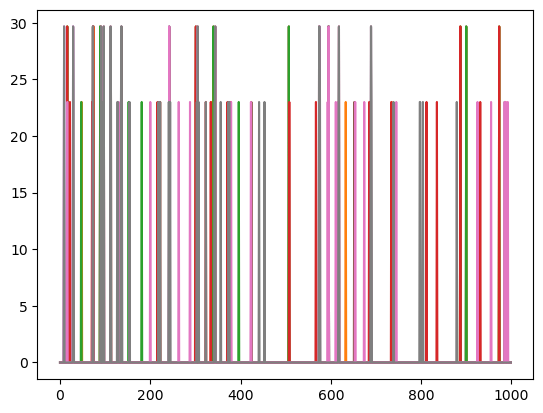

[(array([0, 0, 0, 0, 0, 0, 0, 0]), array([0., 0., 0., 0., 0., 0., 0., 0.]), 5, 0.01), (array([0, 0, 0, 0, 0, 0, 0, 0]), array([0., 0., 0., 0., 0., 0., 0., 0.]), 5, 0.01), (array([0, 0, 0, 0, 0, 0, 0, 0]), array([0., 0., 0., 0., 0., 0., 0., 0.]), 5, 0.01), (array([0, 0, 0, 0, 0, 0, 0, 0]), array([0., 0., 0., 0., 0., 0., 0., 0.]), 5, 0.01), (array([0, 0, 0, 0, 0, 0, 0, 0]), array([0., 0., 0., 0., 0., 0., 0., 0.]), 5, 0.01), (array([0, 0, 0, 0, 0, 0, 0, 0]), array([0., 0., 0., 0., 0., 0., 0., 0.]), 5, 0.01), (array([0, 0, 0, 0, 0, 0, 0, 0]), array([0., 0., 0., 0., 0., 0., 0., 0.]), 5, 0.01), (array([0, 0, 0, 0, 0, 0, 0, 0]), array([0., 0., 0., 0., 0., 0., 0., 0.]), 5, 0.01), (array([0, 0, 0, 0, 0, 0, 0, 0]), array([0., 0., 0., 0., 0., 0., 0., 0.]), 5, 0.01), (array([0, 0, 0, 0, 1, 0, 1, 1]), array([ 0.        ,  0.        ,  0.        ,  0.        , 29.66666667,
        0.        , 29.66666667, 29.66666667]), 4, 0.45), (array([0, 0, 0, 0, 0, 0, 0, 0]), array([0., 0., 0., 0., 0., 0., 0., 0

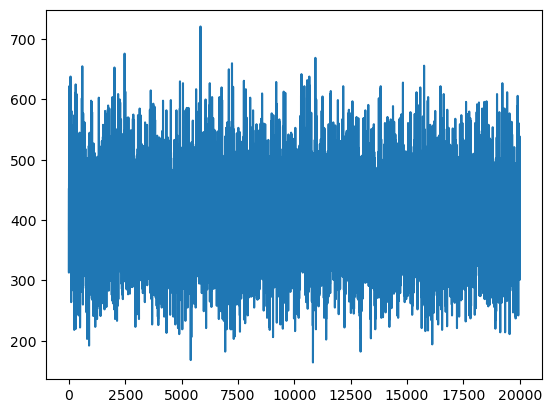

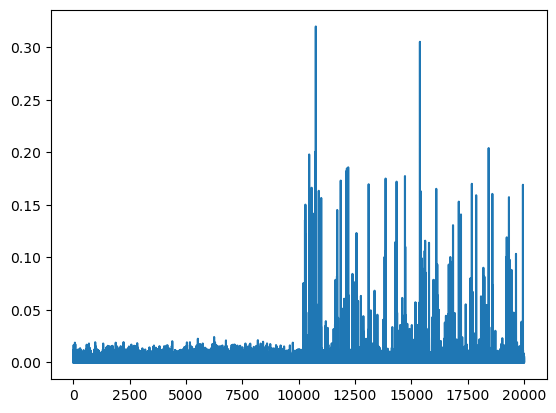

In [17]:
aRecord = dataset['actionsRecord']
rRecord = [r for (w, r, M, alpha) in aRecord]
plt.plot(rRecord[0:1000])
plt.show()
print(aRecord)

uRecord = np.array(dataset['uRecord'])
plt.plot(np.sum(uRecord, axis=1))
plt.show()

rRecord = np.array(dataset['rewardRecord'])
plt.plot(rRecord)
plt.show()

In [8]:
if configIdx == 4:
    envParams = getEnvConfig(0)
    visualizeEnvConfig(envParams)
    predictorParams = getPredictorConfig(configIdx)
    visualizePredictorConfig(predictorParams)
    trafficDataParentPath = f'Results/TrafficData'
    env = createEnv(envParams, trafficDataParentPath)
    env.selectMode(mode="test", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.012
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3
